# cpop: Detecting changes in piecewise-linear signals
## Paul Fearnhead and Daniel Grose

## Section 1

### Figure 1

### simulate data

In [1]:
library(cpop)
set.seed(1)
x <- 1:400
changepoints <- 0:7*50
y <- simchangeslope(x,changepoints=changepoints,change.slope=c(0.5,(-1)^(1:7))/5)
mu <- simchangeslope(x,changepoints=changepoints,change.slope=c(0.5,(-1)^(1:7))/5,sd=0)

Loading required package: crops

Loading required package: pacman



### implement three different methods

#### 1. cpop

In [2]:
res <- cpop(y) 

No value set for beta, so the default value of beta=2log(n), where n is the number of data points, has been used.
This default value is appropriate if the noise is IID Gaussian and the value of sd is a good estimate of the standard
deviation of the noise. If these assumptions do not hold, the estimate of the number of changepoints may be inaccurate.
To check robustness use cpop.crops with beta_min and beta_max arguments.

No value set for sd. An estimate for the noise standard deviation based on the variance of the second differences of
the data has been used. If this estimate is too small it may lead to over-estimation of changepoints. You are advised
to check this by comparing the standard deviation of the residuals to the estimated value used for sd.


#### 2. difference data and analyse as change in mean

In [3]:
dy <- diff(y)

In [4]:
library(changepoint)
out <- cpt.mean(dy,method="PELT",penalty="CROPS",pen.value=c(1*log(399),2*2*log(399)))

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.



[1] "Maximum number of runs of algorithm = 15"
[1] "Completed runs = 2"
[1] "Completed runs = 3"
[1] "Completed runs = 5"
[1] "Completed runs = 7"
[1] "Completed runs = 9"


#### 3. trend filtering

In [5]:
library(genlasso)
out.tf <- trendfilter(y,x,ord=1)
##show two segmentations -- one based on minimising CV
cv <- cv.trendfilter(out.tf)
fit1 <- out.tf$fit[,out.tf$lambda==cv$lambda.min]
sum(abs(diff(diff(fit1)))>0.001) ##17 changes
##one based on the correct number of changes

#to find this we calculate the number of changes as we vary the penalty in trend-filtering
cps <- rep(NA,dim(out.tf$fit)[2])
for(i in 1:dim(out.tf$fit)[2]){
  cps[i] <- sum(abs(diff(diff(out.tf$fit[,i])))>0.001)
}
##inspection gives that the 38th penalty value gives 7 changes.
fit2 <- out.tf$fit[,38]

Loading required package: Matrix

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


[1] 17

In [6]:
library(ggplot2)

In [7]:
df <- data.frame("x" = x, "y" = y,"dy"=  c(NA,dy))

In [9]:
p.1 <- ggplot(data = df, aes(x = x, y = y))
p.1 <- p.1 + geom_point(alpha=0.4)
p.1 <- p.1 + geom_line(aes(y = mu), color = "blue")
p.1 <- p.1 + theme_bw()
p.1 <- p.1 + xlab("Time") + ylab("Data")

In [10]:
p.2 <- ggplot(data = df, aes(x = x, y = dy))
p.2 <- p.2 + geom_point(alpha=0.4)
p.2 <- p.2 + geom_vline(xintercept = changepoints[-1],color = "blue",linetype = "dashed")
p.2 <- p.2 + geom_vline(xintercept = cpts.full(out)[3,],color = "red",linetype = "dashed")
p.2 <- p.2 + theme_bw()
p.2 <- p.2 + xlab("Time") + ylab("First Differences")

In [11]:
p.3 <- ggplot(data = df, aes(x = x, y = y))
p.3 <- p.3 + geom_point(alpha=0.4)
p.3 <- p.3 + geom_line(aes(y = mu), color = "blue")
p.3 <- p.3 + geom_line(aes(y = fit1), color = "red")
p.3 <- p.3 + geom_vline(xintercept = changepoints[-1],color = "blue",linetype = "dashed")
p.3 <- p.3 + geom_vline(xintercept = (1:399)[abs(diff(diff(fit1)))>0.001]+1,color = "red",linetype = "dashed")
p.3 <- p.3 + theme_bw()
p.3 <- p.3 + xlab("Time") + ylab("Data")

In [12]:
p.4 <- ggplot(data = df, aes(x = x, y = y))
p.4 <- p.4 + geom_point(alpha=0.4)
p.4 <- p.4 + geom_line(aes(y = mu), color = "blue")
p.4 <- p.4 + geom_line(aes(y = fit2), color = "red")
p.4 <- p.4 + geom_vline(xintercept = changepoints[-1],color = "blue",linetype = "dashed")
p.4 <- p.4 + geom_vline(xintercept = (1:399)[abs(diff(diff(fit2)))>0.001]+1,color = "red",linetype = "dashed")
p.4 <- p.4 + theme_bw()
p.4 <- p.4 + xlab("Time") + ylab("Data")

In [13]:
library(gridExtra)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_vline()`).”


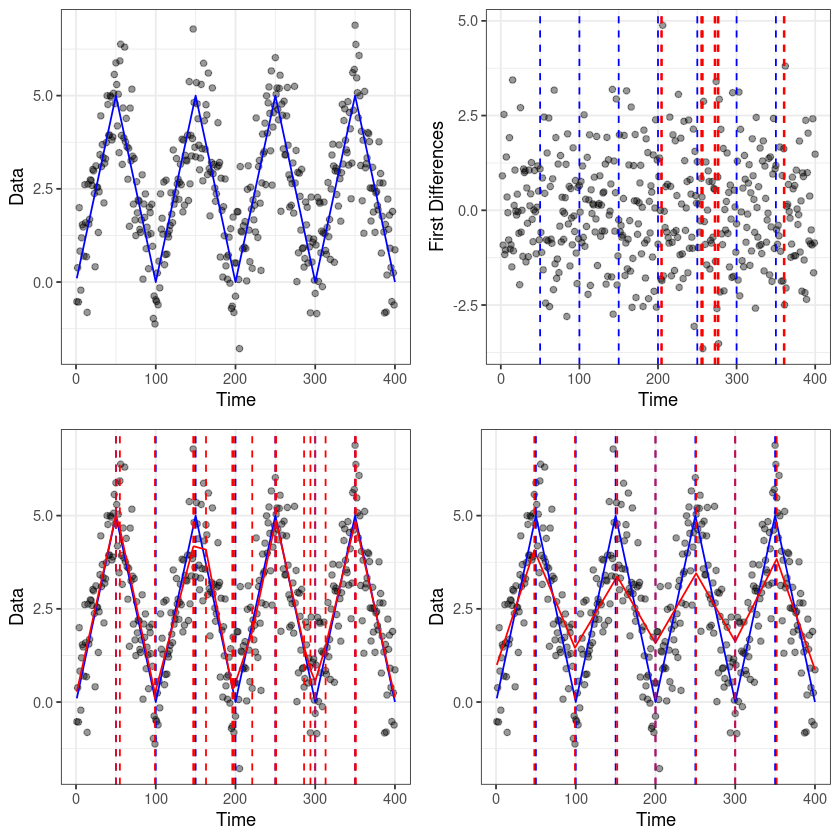

In [14]:
g <- grid.arrange(p.1,p.2,p.3,p.4 ,nrow = 2,ncol=2)

In [15]:
ggsave(file="change_in_slope_examples_ggplot.pdf", g)

Saving 6.67 x 6.67 in image


## Section 3.1

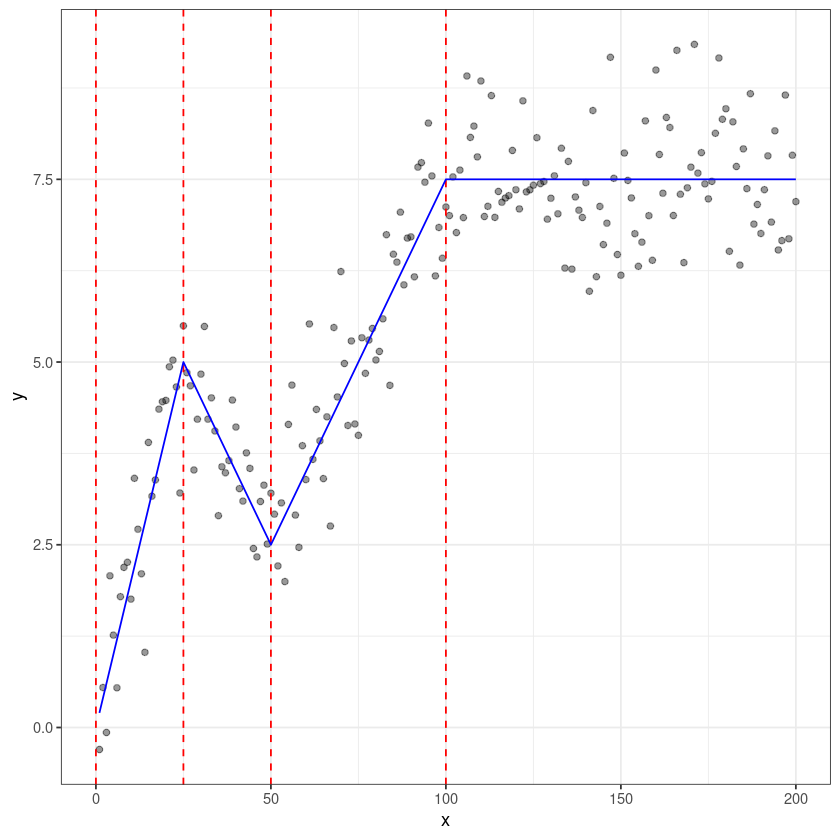

In [16]:
set.seed(1)
changepoints <- c(0, 25, 50, 100)
change.slope <- c(0.2, -0.3, 0.2, -0.1)
x <- 1:200
sd <- 0.8
y <- simchangeslope(x, changepoints, change.slope, sd) #simulate data
df <- data.frame("x" = x, "y" = y)
p <- ggplot(data = df, aes(x = x, y = y))
p <- p + geom_point(alpha=0.4)
p <- p + geom_vline(xintercept = changepoints, color = "red",  linetype = "dashed")

#for the plot: obtain the true mean function by setting sd=0.
mu <- simchangeslope(x, changepoints, change.slope, sd = 0)
p <- p + geom_line(aes(y = mu), color = "blue")
p <- p + theme_bw()
print(p)

### Figure 2

In [17]:
ggsave(file="simulate_example_ggplot.pdf",p)

Saving 6.67 x 6.67 in image


## Section 3.2

In [18]:
##analysis by cpop
res <- cpop(y, x, beta = 2*log(length(y)), sd = 0.8)
summary(res)


cpop analysis with n = 200 and penalty (beta)  = 10.59663

3  changepoints detected at x = 
 22 52 95
fitted values : 
  x0       y0  x1       y1     gradient   intercept      RSS
1  1 0.147335  22 4.844725  0.223685242 -0.07635023 10.07761
2 22 4.844725  52 2.717661 -0.070902123  6.40457180 10.38813
3 52 2.717661  95 7.303644  0.106650750 -2.82817758 25.09463
4 95 7.303644 200 7.563413  0.002473995  7.06861408 61.78303

overall RSS = 107.3434
cost = 199.514



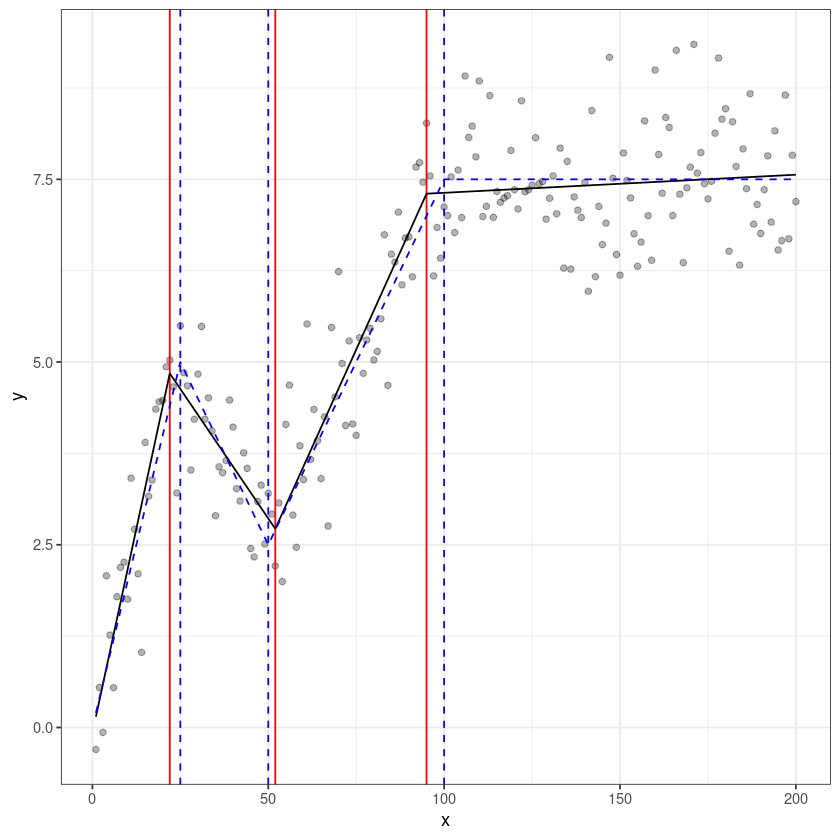

In [19]:
p <- plot(res)
p <- p + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p <- p + geom_line(aes(y = mu), color = "blue", linetype = "dashed")
print(p)

### Figure 3

In [20]:
ggsave(file="cpop_example1_ggplot.pdf",p)

Saving 6.67 x 6.67 in image


## Section 3.3

In [21]:
changepoints(res)

location
<int>
22
52
95


In [22]:
estimate(res, x = c(0.1,2.7,51.6))

x,y_hat
<dbl>,<dbl>
0.1,-0.0539817
2.7,0.5275999
51.6,2.7460223


In [23]:
fitted(res)

x0,y0,x1,y1,gradient,intercept,RSS
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.147335,22,4.844725,0.223685242,-0.07635023,10.07761
22,4.844725,52,2.717661,-0.070902123,6.40457180,10.38813
52,2.717661,95,7.303644,0.106650750,-2.82817758,25.09463
95,7.303644,200,7.563413,0.002473995,7.06861408,61.78303


## Section 4.1

In [24]:
set.seed(1)
x <- (1:200)^(2)/(200) ###x-values now unevenly spaced
changepoints <- c(0, 25, 50, 100)
change.slope <- c(0.2, -0.3, 0.2, -0.1)
y <- simchangeslope(x, changepoints, change.slope, sd) #simulate data
##analysis by cpop
res <- cpop(y, x, beta = 2*log(length(y)), sd = 0.8)

### Figure 4

Saving 6.67 x 6.67 in image


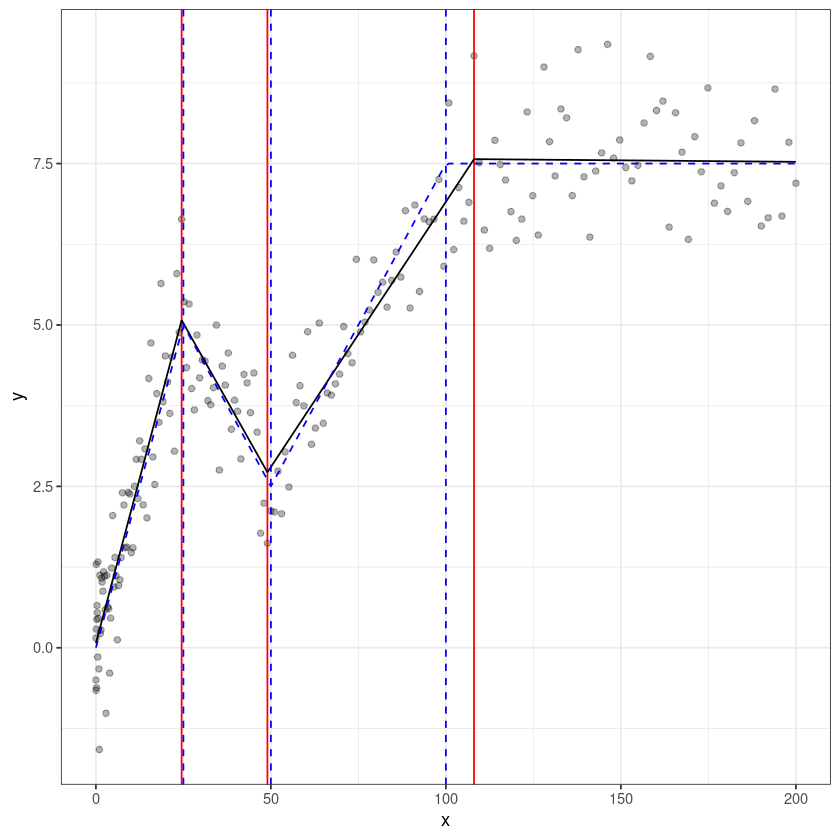

In [25]:
#for the plot: obtain the true mean function by setting sd=0.
mu <- simchangeslope(x, changepoints, change.slope, sd = 0)
p <- plot(res)
p <- p + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p <- p + geom_line(aes(y = mu), color = "blue", linetype = "dashed")
print(p)
ggsave(file="cpop_example_uneven_ggplot.pdf",p)

## Section 4.1

In [27]:
set.seed(1)
changepoints <- c(0, 25, 50, 100)
change.slope <- c(0.2, -0.3, 0.2, -0.1)
x <- 1:200 
sd <- x/100
y <- simchangeslope(x, changepoints, change.slope, sd) #simulate data
##analysis by cpop
res <- cpop(y, x,  beta = 2*log(length(y)), sd = sqrt(mean(sd^2)) )
#summary(res)
res.true <- cpop(y, x, beta = 2*log(length(y)), sd=sd)

### Figure 5

Saving 6.67 x 6.67 in image


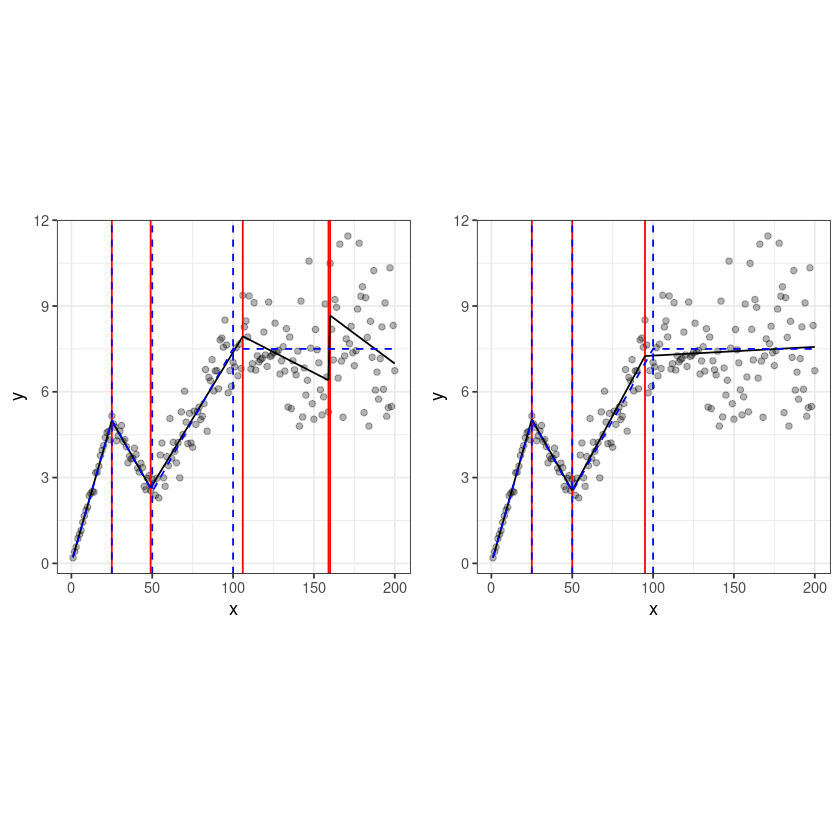

In [28]:
mu <- simchangeslope(x, changepoints, change.slope, sd = 0)
p <- plot(res)
p <- p + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p <- p + geom_line(aes(y = mu), color = "blue", linetype = "dashed")

p.true <- plot(res.true)
p.true <- p.true + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p.true <- p.true + geom_line(aes(y = mu), color = "blue", linetype = "dashed")
p <- p + theme(aspect.ratio=1/1)
p.true <- p.true + theme(aspect.ratio=1/1)
g <- grid.arrange(p,p.true,nrow=1,ncol=2)
ggsave(file="cpop_uneven_examples_ggplot.pdf",g)

## Section 4.3

In [31]:
set.seed(1)
x <- 1:6400
y <- simchangeslope(x, changepoints = 0:31*200, change.slope = c(0.05,0.1*(-1)^(1:(31))), sd = 1)

res.coarse <- cpop(y, x, grid=1:399*16, beta = 2*log(400), sd = 1)
cps <- unlist( changepoints(res.coarse) )

grid <- NULL
for(i in 1:length(cps)){
  grid <- c(grid, cps[i] + (-7):8 )
}

res.fine <- cpop(y, x, grid, beta = 2*log(length(x)), sd = 1)


### Figure 6

In [32]:
 set.seed(1)
  n.st <- 200*2^(0:5)
  ##scenario 1 -- one changepoint
  K <- 10 ##number of replications
  time1 <- matrix(NA,nrow=K,ncol=length(n.st))
  time1g <- matrix(NA,nrow=K,ncol=length(n.st))
  for(i in 1:length(n.st)){
    n <- n.st[i]
    for(k in 1:K){
      y <- simchangeslope(1:n,n/2,0.5,1)
      time1[k,i] <- (system.time(cpop(y, beta = 2*log(length(y)), sd = 1)))[1]
      time1g[k,i] <- (system.time(cpop(y, beta = 2*log(length(y)),sd = 1, grid=(1:n.st[1])*(n/n.st[1]))))[1]
    }
  }
  
  n.st <- 200*2^(0:5)
  ##scenario 2 -- linear increasing changepoint
  K <- 10 ##number of replications
  time2 <- matrix(NA,nrow=K,ncol=length(n.st))
  time2g <- matrix(NA,nrow=K,ncol=length(n.st))
  for(i in 1:length(n.st)){
    n <- n.st[i]
    for(k in 1:K){
      m <- 2*n/n.st[1]
      y <- simchangeslope(1:n,0:(m-1)*n/m,c(0.05,0.1*(-1)^(1:(m-1))),1)
      time2[k,i] <- (system.time(cpop(y, beta = 2*log(length(y)),sd = 1)))[1]
      time2g[k,i] <- (system.time(cpop(y, beta = 2*log(length(y)), sd = 1, grid=(1:n.st[1])*(n/n.st[1]))))[1]
    }
  }
#  save(time1,time2,time1g,time2g,file="/Users/paulfearnhead/Dropbox/Apps/Overleaf/JSS: CPOP/time.Rdata")
#    load("/Users/paulfearnhead/Dropbox/Apps/Overleaf/JSS: CPOP/time.Rdata")

###average the times
t1 <- apply(time1,2,mean)
t2 <- apply(time2,2,mean)
t1g <- apply(time1g,2,mean)
t2g <- apply(time2g,2,mean)

Saving 6.67 x 6.67 in image



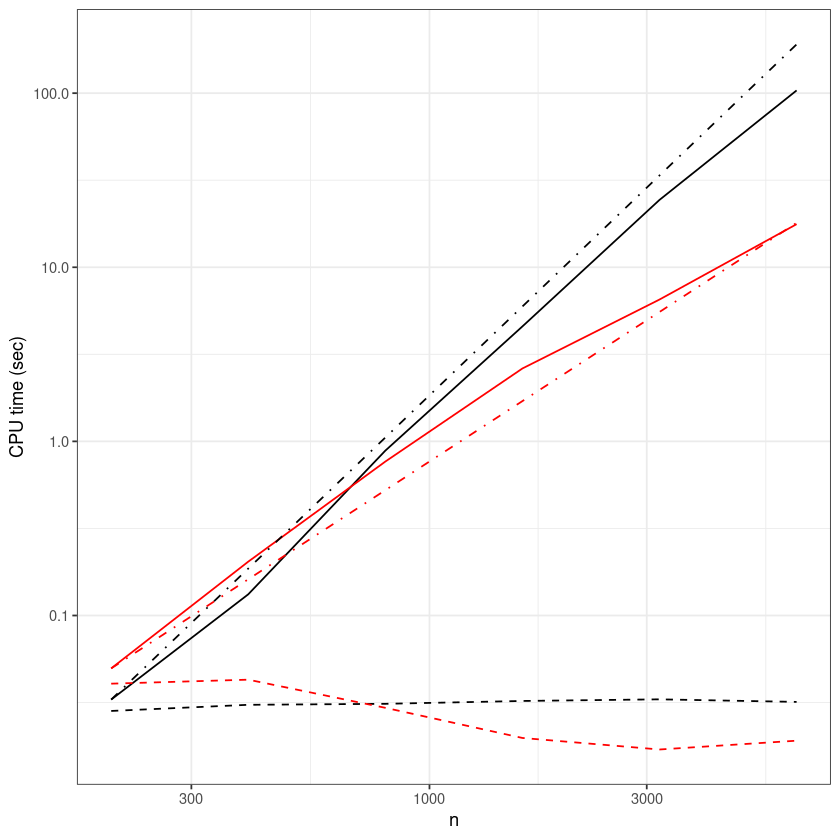

In [29]:
df <- data.frame("x" = n.st,
                "t1" = t1,
                "t2" = t2,
                "t1g" = t1g,
                "t2g" = t2g,
                "d1" = t2[1]*n.st^1.7/n.st[1]^1.7,
                "d2" = t1[1]*n.st^2.5/n.st[1]^2.5)
p <- ggplot(data = df, aes(x = x))
p <- p + geom_line(aes(y = t1))
p <- p + geom_line(aes(y = t2),color="red")
p <- p + geom_line(aes(y = t1g),linetype = "dashed")
p <- p + geom_line(aes(y = t2g),linetype = "dashed",color="red")
p <- p + geom_line(aes(y = d1),linetype = "5515",color="red")
p <- p + geom_line(aes(y = d2),linetype = "5515")
p <- p + scale_x_continuous(trans = 'log10')
p <- p + scale_y_continuous(trans = 'log10')
p <- p + xlab("n") + ylab("CPU time (sec)")
p <- p + theme_bw()
print(p)
ggsave(file="cpop_CPU_ggplot.pdf", p)

## Section 4.4

In [33]:
set.seed(1)
##simulate data as for Section 3
changepoints <- c(0, 25, 50, 100)
change.slope <- c(0.2, -0.3, 0.2, -0.1)
x <- 1:200
mu <- simchangeslope(x, changepoints, change.slope, sd = 0) #mean

##simulate data with t noise
y <- mu + rt(length(x), df = 4)
res.min <- cpop(y,x, beta=2*log(length(y)), minseglen = 10, sd = sqrt(2)) ##variance of t_d is d/(d-2)

### Figure 7

In [34]:

res <- cpop(y,x, beta=2*log(length(y)), sd = sqrt(2)) ##variance of t_d is d/(d-2)

##Now run with a minimum segment length
#res.min=cpop(y,x,beta=2*(log(length(y))),minseglen=10, sd = sqrt(4/2))
##compare CPU cost
system.time(cpop(y,x, beta=2*log(length(y)), sd = sqrt(2) ) )[1]
system.time(cpop(y,x,beta=2*(log(length(y))),minseglen=10, sd = sqrt(2) ) )[1]

##run with too large a minimum segment length
res.min40=cpop(y,x,beta = 2*(log(length(y))), minseglen = 40, sd = sqrt(2))
res.min30=cpop(y,x,beta = 2*(log(length(y))), minseglen = 30, sd = sqrt(2))



user.self 
    0.036

user.self 
    0.614

In [35]:
p.1 <- plot(res)
p.1 <- p.1 + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p.1 <- p.1 + geom_line(aes(y = mu), color = "blue", linetype = "dashed")


p.2 <- plot(res.min)
p.2 <- p.2 + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p.2 <- p.2 + geom_line(aes(y = mu), color = "blue", linetype = "dashed")

p.3 <- plot(res.min30)
p.3 <- p.3 + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p.3 <- p.3 + geom_line(aes(y = mu), color = "blue", linetype = "dashed")

p.4 <- plot(res.min40)
p.4 <- p.4 + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p.4 <- p.4 + geom_line(aes(y = mu), color = "blue", linetype = "dashed")


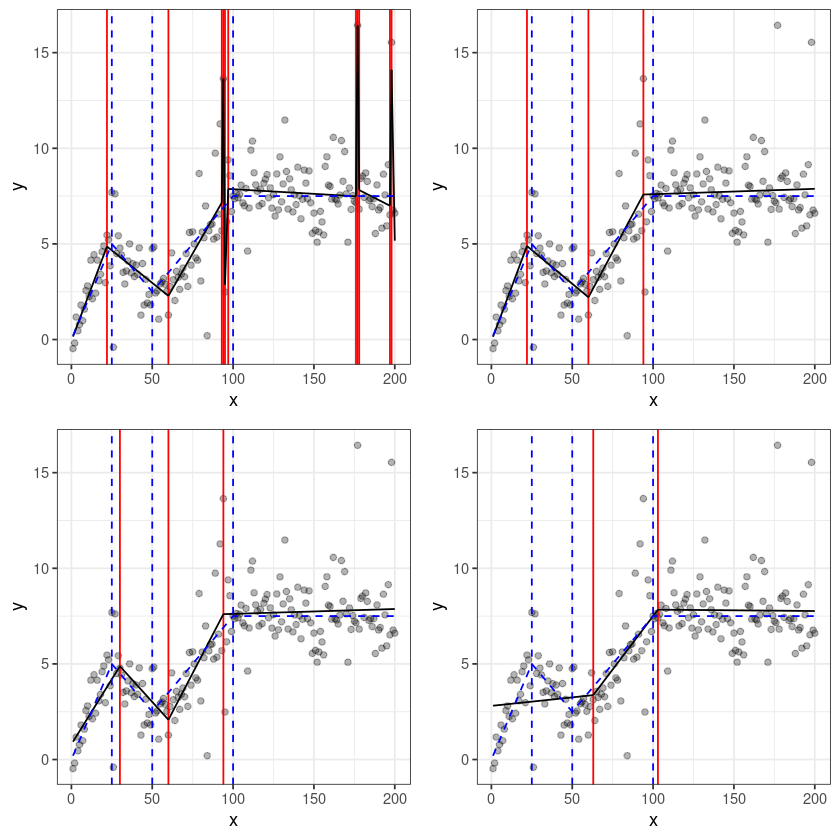

In [33]:
g <- grid.arrange(p.1,p.2,p.3,p.4 ,nrow = 2,ncol=2)

In [34]:
ggsave(file="cpop_minseg_ggplot.pdf", g)

Saving 6.67 x 6.67 in image



## Section 4.5

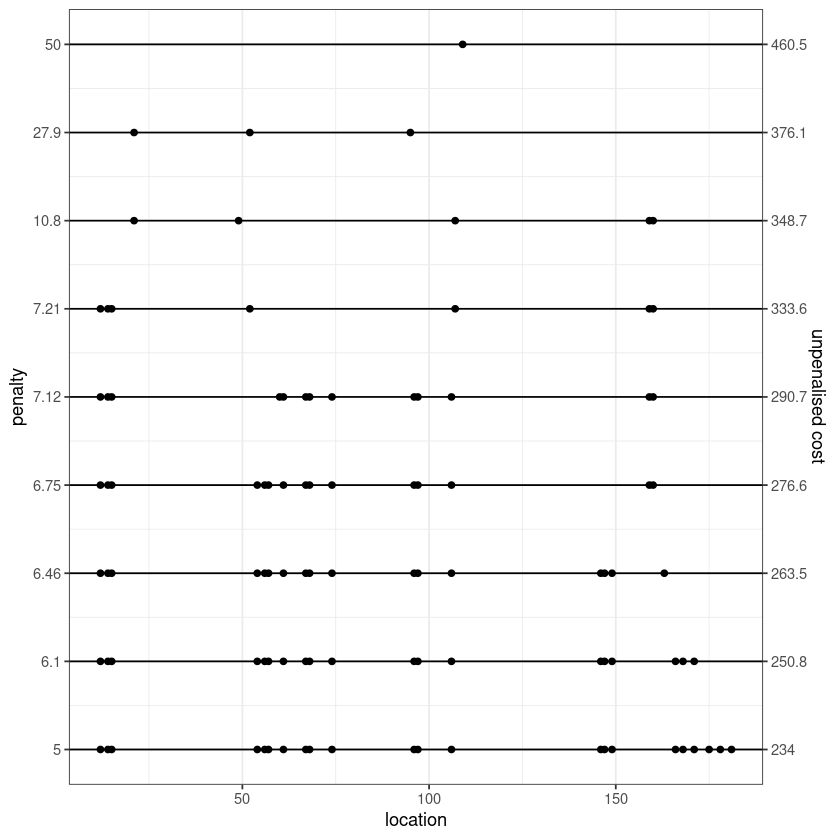

In [45]:
set.seed(1)
##simulate data as for Section 3
changepoints <- c(0, 25, 50, 100)
change.slope <- c(0.2, -0.3, 0.2, -0.1)
x <- 1:200
mu <- simchangeslope(x, changepoints, change.slope,  0) #mean
y <- simchangeslope(x, changepoints, change.slope, 1.5) #data with sd=1.5
###run crops
res.crops <- cpop.crops(y , x, beta_min= 5 ,beta_max= 50,sd=1)
plot(res.crops)

In [46]:
##calculate the BIC under a model of unknown variance
models <- cpop.crops.models(res.crops)
M <- length(models)
BIC <- rep(NA, M)
ncps <- segmentations( res.crops )[,4]
n <- length(y)
for(i in 1:M){
  BIC[i] <- n*log( mean( ( residuals(models[[i]]) )^2) )+ 2 * ncps[i]  * log(n)
}


### Figure 8

Saving 6.67 x 6.67 in image


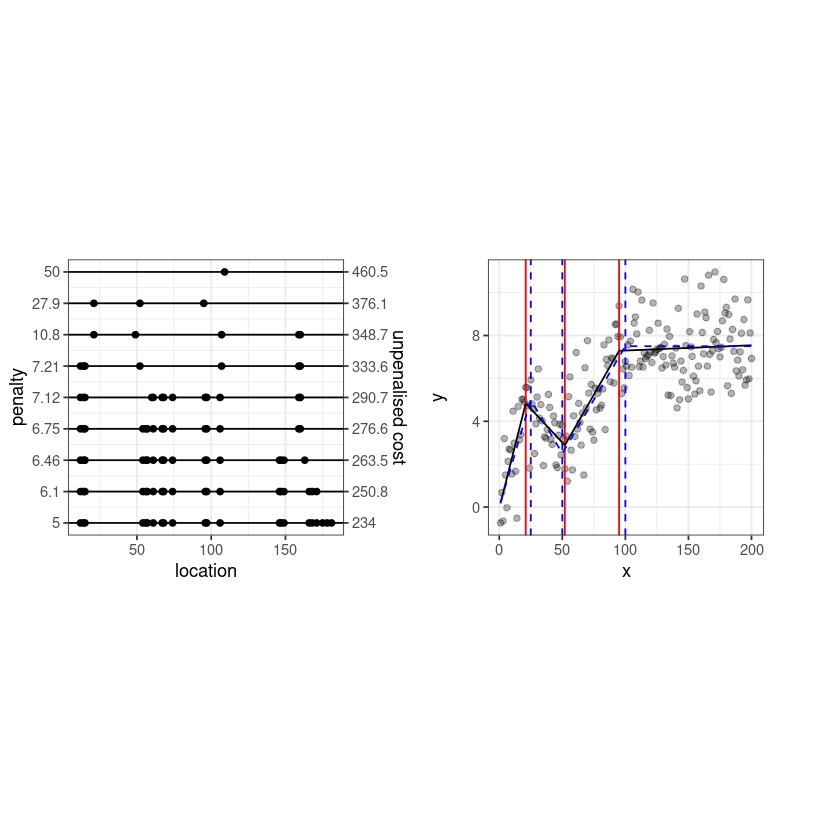

In [47]:
p.1 <- plot(res.crops)
i <- which.min(BIC)
p.2 <- plot(models[[i]])
p.2 <- p.2 + geom_vline(xintercept = changepoints[-1], color = "blue", linetype = "dashed")
p.2 <- p.2 + geom_line(aes(y = mu), color = "blue", linetype = "dashed")
p.1 <- p.1 + theme(aspect.ratio=1/1)
p.2 <- p.2 + theme(aspect.ratio=1/1)
library(cowplot)
g <- plot_grid(p.1, p.2, align = "v", nrow = 1)
ggsave(file="cpop_crops_example_ggplot.pdf",g)
plot(g)

In [48]:
set.seed(1)
n <- 500
x <- 1:n
mu <- simchangeslope(x,changepoints = 45*0:10,change.slope = c(0.15,0.3*(-1)^(1:10)) ,sd = 0)
epsilon <- rnorm(n+2)
y <- mu + (epsilon[1:n] + epsilon[2:(n+1)] + epsilon[3:(n+2)]) /sqrt(3)

In [49]:
res.crops <- cpop.crops(y,x,beta_min=8,beta_max=200,sd=1)
segs <- segmentations(res.crops)

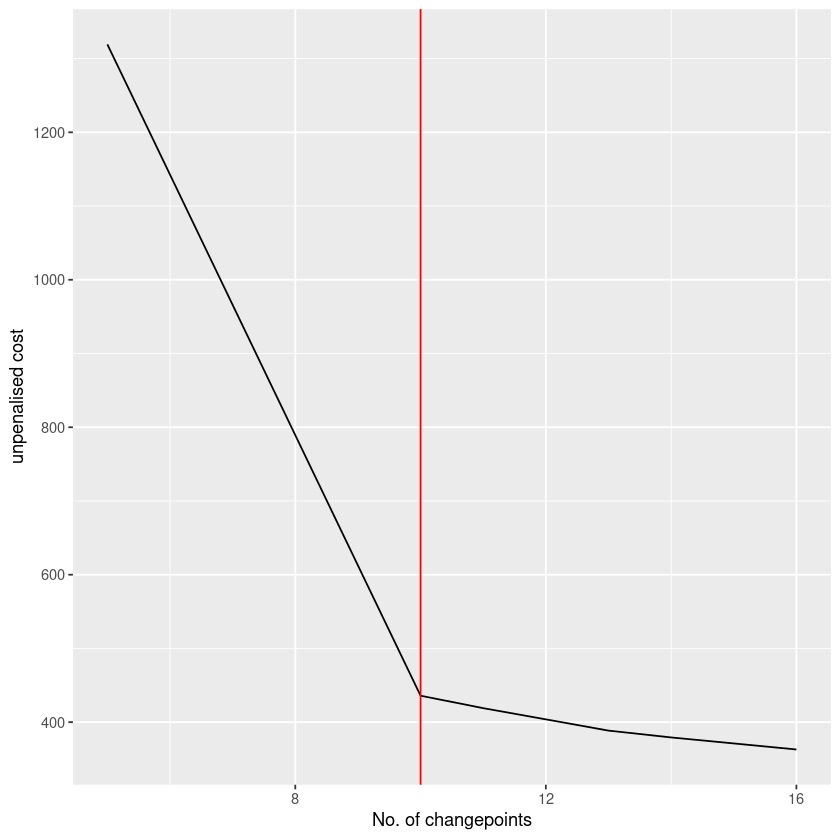

In [50]:
p <- ggplot(data = segs, aes(x = m))
p <- p + geom_line(aes(y = Qm))
p <- p + geom_vline(xintercept = 10,color = "red")
p <- p + xlab("No. of changepoints") + ylab("unpenalised cost")
plot(p)

### Figure 9

In [51]:
set.seed(1)
n <- 500
x <- 1:n
mu <- simchangeslope(x,changepoints = 45*0:10,change.slope = c(0.15,0.3*(-1)^(1:10)) ,sd = 0)
epsilon <- rnorm(n+2)
y <- mu + (epsilon[1:n] + epsilon[2:(n+1)] + epsilon[3:(n+2)]) /sqrt(3)
p.1 <- plot(res.crops)
p.2 <- p + theme_bw()
models <- cpop.crops.models(res.crops)
p <- plot(models[[5]])
p <- p + geom_vline(xintercept = 45*1:10, color = "blue", linetype = "dashed")
p.3 <- p + geom_line(aes(y = mu), color = "blue", linetype = "dashed")

Saving 6.67 x 6.67 in image


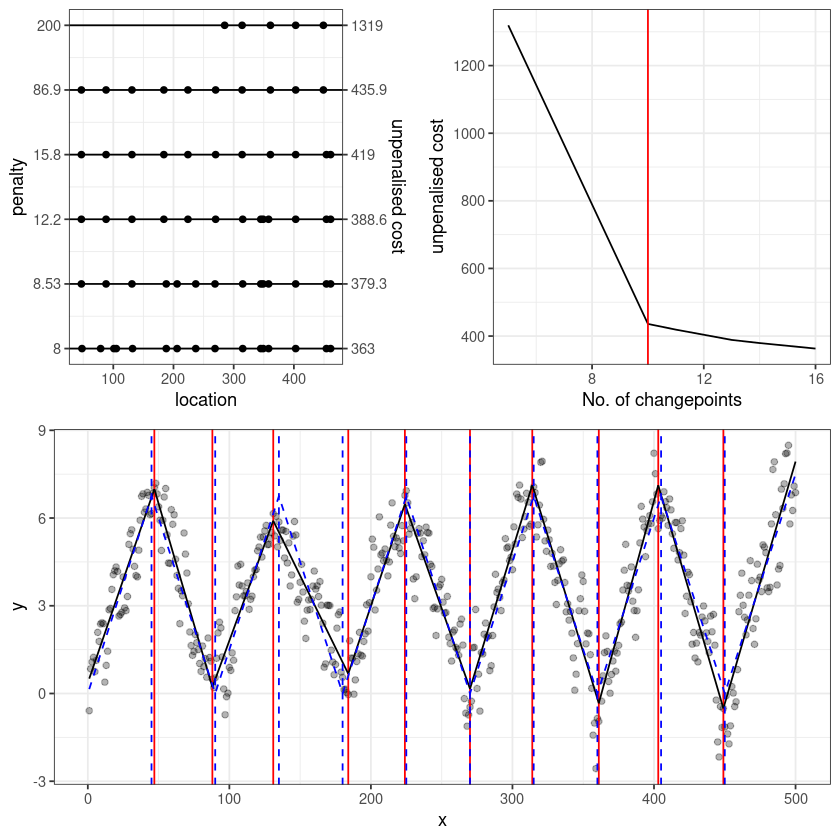

In [52]:
g <- grid.arrange(p.1,p.2,p.3,layout_matrix=rbind(c(1,2),c(3,3)))
ggsave(file="cpop_crops_ggplot.pdf",g)

## Section 5

In [53]:
data("wavenumber_spectra") ##Load data

##example for one curve -- fitting the decay.
x <- log(wavenumber_spectra[-(1:3),1],base=10)
y <- log(wavenumber_spectra[-(1:3),4],base=10)

grid <- seq(from=min(x),to=max(x),length=200)
##naive estimator of variance
sig2 <- mean( diff( diff(y) )^2 )/6 ##simple estimate of variance 

res <- cpop(y, x, grid, sd=sqrt(sig2), minseg = 0.09, beta=2*log(200))

In [54]:
r2 <- residuals(res)^2
##estimate variance as exp(a+bx)
##function for minus twice log-likelihood
loglik <- function(par){ 
  return(length(r2) * par[1] + par[2] * sum(x) + sum( r2/ (exp(par[1]+par[2]*x) )) )
}

est.hat <- optim( c(0,0) , loglik)
sig2 <- exp(est.hat$par[1] + est.hat$par[2]*x)

res2 <- cpop(y, x, grid , sd=sqrt(sig2), minseg= 0.09, beta=2 * log(200))

### Figure 10

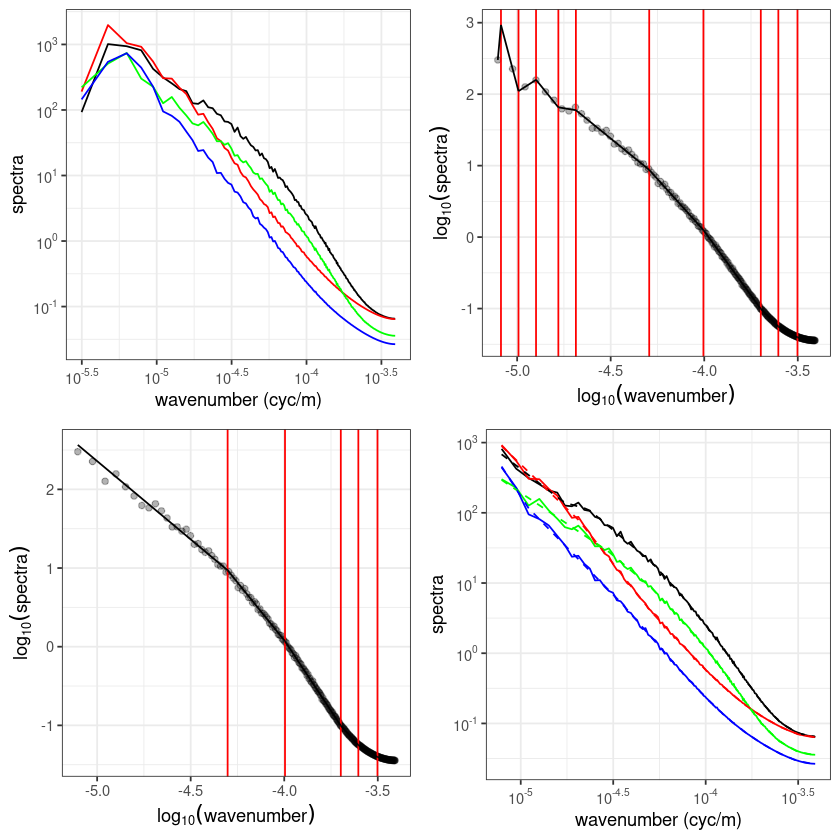

In [55]:
library(scales)
library(latex2exp)

######FUNCTION TO AUTOMATE THIS ANALYSIS
wavenumber_est <- function(x,y){
  grid <- seq(from=min(x),to=max(x),length=200)
  ##naive estimator of variance
  sig2 <- mean( diff( diff(y) )^2 )/6 ##simple estimate of variance 
  
  res <- cpop(y, x, grid, sd=sqrt(sig2), minseg = 0.09, beta=2*log(200))
 
  r2 <- residuals(res)^2
  est.hat <- optim( c(0,0) , loglik)
  sig2 <- exp(est.hat$par[1] + est.hat$par[2]*x)
  
  res2 <- cpop(y, x, grid , sd=sqrt(sig2), minseg = 0.09, beta=2 * log(200))
  
  return(res2)
}

y.est <- matrix(NA,nrow=4,ncol=length(x))
for(j in 1:4){
  est <- wavenumber_est(x, log(wavenumber_spectra[-(1:3),1+j]))
  y.est[j, ] <- estimate(est,x)[,2]
}

p <- ggplot(data = wavenumber_spectra, aes(x = wavenumber))
p <- p + geom_line(aes(y = power_spectra_Feb2000),color="black")
p <- p + geom_line(aes(y = power_spectra_Aug2000),color="red")
p <- p + geom_line(aes(y = power_spectra_Feb2100),color="green")
p <- p + geom_line(aes(y = power_spectra_Aug2100),color="blue")
# p <- p + scale_x_continuous(trans = 'log10')
p <- p + scale_x_continuous(trans = 'log10',breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x)))
p <- p + scale_y_continuous(trans = 'log10',breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x)))
# p <- p + xlab("wavenumber (cyc/m)") + ylab("log_10 spectra")
# p <- p + xlab("wavenumber (cyc/m)") +    ylab(TeX("$\\log_{10}$ spectra"))
p <- p + xlab("wavenumber (cyc/m)") +    ylab("spectra")                            
p.1 <- p + theme_bw()

p.2 <- plot(res)
p.2 <- p.2 + xlab(TeX("$\\log_{10}(wavenumber)$")) +    ylab(TeX("$\\log_{10}(spectra)$"))                            

p.3 <- plot(res2)
p.3 <- p.3 + xlab(TeX("$\\log_{10}(wavenumber)$")) +    ylab(TeX("$\\log_{10}(spectra)$")) 
#p.3 <- p.3 + scale_y_continuous(labels=function(.) sprintf("%.1f", .))

df <- wavenumber_spectra[-(1:3),]
p <- ggplot(data = df, aes(x = wavenumber))
p <- p + geom_line(aes(y = power_spectra_Feb2000),color="black")
p <- p + geom_line(aes(y = power_spectra_Aug2000),color="red")
p <- p + geom_line(aes(y = power_spectra_Feb2100),color="green")
p <- p + geom_line(aes(y = power_spectra_Aug2100),color="blue")
p <- p + geom_line(aes(y = exp(y.est[1,])),color="black",linetype="dashed")
p <- p + geom_line(aes(y = exp(y.est[2,])),color="red",linetype="dashed")
p <- p + geom_line(aes(y = exp(y.est[3,])),color="green",linetype="dashed")
p <- p + geom_line(aes(y = exp(y.est[4,])),color="blue",linetype="dashed")
#p <- p + scale_x_continuous(trans = 'log10')
p <- p + scale_x_continuous(trans = 'log10',breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x)))
p <- p + scale_y_continuous(trans = 'log10',breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x)))
p <- p + xlab("wavenumber (cyc/m)") + ylab("spectra")
p.4 <- p + theme_bw()

g <- grid.arrange(p.1,p.2,p.3,p.4,nrow=2,ncol=2)

In [56]:
ggsave(file="cpop_real_data_ggplot.pdf",g)

Saving 6.67 x 6.67 in image
